In [32]:
import os
import re
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [33]:
train_dir = "/kaggle/input/fer2013plus/fer2013plus/fer2013/train/"
teste_dir = "/kaggle/input/fer2013plus/fer2013plus/fer2013/test/"


# Modelo a ser utilizado
cnn_modelo = "MobileNetV2"  # Modelos disponíveis: InceptionV3, MobileNetV2, ResNet50, EfficientNetB0, cnn_tcc_will

EPOCHS = 100

# Set the data generators
BATCH_SIZE=64

print(f"Versão do TensorFlow: {tf.__version__}")
print(f"Modelo Selecionado: {cnn_modelo}")

Versão do TensorFlow: 2.17.1
Modelo Selecionado: MobileNetV2


In [34]:
try:
    if cnn_modelo == "InceptionV3":
        from tensorflow.keras.applications import InceptionV3
        from tensorflow.keras.layers import GlobalAveragePooling2D
        classes = 8

    elif cnn_modelo == "EfficientNetB0":
        from tensorflow.keras.applications import EfficientNetB0
        from tensorflow.keras.layers import GlobalAveragePooling2D
        classes = 8
    
    elif cnn_modelo == "MobileNetV2":
        from tensorflow.keras.applications import MobileNetV2
        from tensorflow.keras.layers import GlobalAveragePooling2D
        classes = 8
    
    elif cnn_modelo == "ResNet50":
        from tensorflow.keras.applications import ResNet50
        from tensorflow.keras.layers import GlobalAveragePooling2D
        classes = 8
    
    elif cnn_modelo == "cnn_tcc_will":
        from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Input
        classes = 7

    else:
        print(f"{cnn_modelo} não localizado")
        raise ValueError("Modelo não suportado")

except Exception as e:
    print(f"Erro ao carregar modelo: {e}")
    exit()

print(f"libs para o modelo {cnn_modelo} carregado!")

libs para o modelo MobileNetV2 carregado!


In [35]:
def count_exp(path, set_):
    dict_ = {}
    if os.path.exists(path):  # Verifica se o diretório principal existe
        for expression in os.listdir(path):
            dir_ = os.path.join(path, expression)  # Usa os.path.join para caminhos
            if os.path.isdir(dir_): #Verifica se é um diretório
                dict_[expression] = len(os.listdir(dir_))
            else:
                print(f"Aviso:{dir_} não é um diretório")
    else:
        print(f"Erro: Diretório {path} não encontrado.")
        return pd.DataFrame() # Retorna um DataFrame vazio em caso de erro

    df = pd.DataFrame(dict_, index=[set_])
    return df

# Exemplo de uso (substitua pelos seus caminhos reais)
train_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train/' #Caminho corrigido
teste_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test' 

train_count = count_exp(train_dir, 'train')
teste_count = count_exp(teste_dir, 'test')

if not train_count.empty:
    print("Contagem de treino:")
    print(train_count)

if not teste_count.empty:
    print("\nContagem de teste:")
    print(teste_count)

Contagem de treino:
       surprise  fear  neutral  sadness  disgust  contempt  happiness  anger
train      3562   652    10308     3514      191       165       7528   2466

Contagem de teste:
      surprise  fear  neutral  sadness  disgust  contempt  happiness  anger
test       900   167     2597      856       57        51       1827    644


<Figure size 1200x600 with 0 Axes>

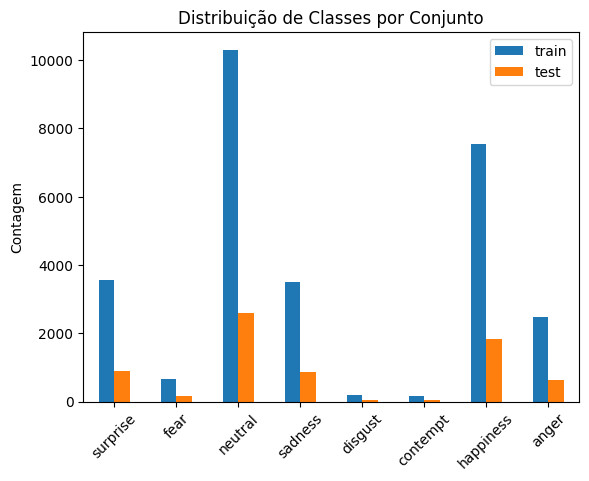

In [36]:
# Plotagem melhorada
plt.figure(figsize=(12, 6))
pd.concat([count_exp(train_dir, 'train'), count_exp(teste_dir, 'test')]).T.plot(kind='bar')
plt.title('Distribuição de Classes por Conjunto')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

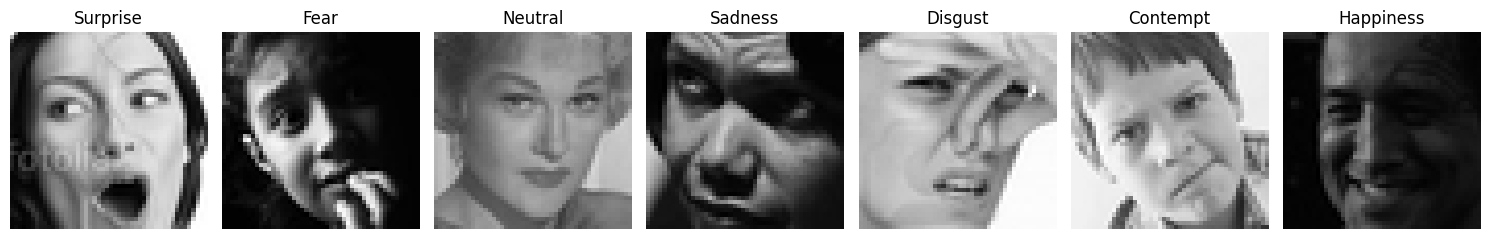

In [37]:
plt.figure(figsize=(15, 6))
emotions = os.listdir(train_dir)

for idx, emotion in enumerate(emotions[:7]):
    img_path = os.path.join(train_dir, emotion, os.listdir(os.path.join(train_dir, emotion))[0])
    img = load_img(img_path)
    
    plt.subplot(1, 7, idx+1)
    plt.imshow(img)
    plt.title(emotion.capitalize())
    plt.axis('off')

plt.tight_layout()
plt.show()

In [38]:
def gera_datagen_models (row: int, col: int, color_mode: str):

    train_datagen = ImageDataGenerator(rescale=1./255,
                                        horizontal_flip=True,
                                        validation_split=0.2)

    training_set = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(row, col),  # Tamanho correto aqui
                                                    shuffle=True,
                                                    color_mode=color_mode,  # Modo de cor correto aqui
                                                    class_mode='categorical',
                                                    subset='training')

    validation_set = train_datagen.flow_from_directory(train_dir,
                                                        batch_size=BATCH_SIZE,
                                                        target_size=(row, col),  # Tamanho correto aqui
                                                        shuffle=True,
                                                        color_mode=color_mode,  # Modo de cor correto aqui
                                                        class_mode='categorical',
                                                        subset='validation')

    test_datagen = ImageDataGenerator(rescale=1./255,
                                        horizontal_flip=True)

    test_set = test_datagen.flow_from_directory(teste_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=(row, col),  # Tamanho correto aqui
                                                shuffle=True,
                                                color_mode=color_mode,  # Modo de cor correto aqui
                                                class_mode='categorical')

    return training_set, validation_set, test_set

In [39]:
if cnn_modelo in ["InceptionV3", "EfficientNetB0","MobileNetV2", "ResNet50"]:
    from tensorflow.keras.applications import InceptionV3
    from tensorflow.keras.layers import GlobalAveragePooling2D
    training_set, validation_set, test_set = gera_datagen_models(224,224,'rgb')

    
elif cnn_modelo == "cnn_tcc_will":
    from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Input
    training_set, validation_set, test_set = gera_datagen_models(48,48,'grayscale')
    

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [40]:
training_set.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happiness': 4,
 'neutral': 5,
 'sadness': 6,
 'surprise': 7}

In [41]:
if cnn_modelo == "cnn_tcc_will":

    weight_decay = 1e-4
    num_classes = 8

    input_tensor = Input(shape=(48, 48, 1))  # Define a camada de entrada

    model = tf.keras.models.Sequential([input_tensor]) # Passa a camada de entrada para o Sequential

    model.add(Conv2D(64, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay))) # input_shape removido
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation="linear"))
    model.add(Activation('elu'))
    model.add(Dense(num_classes, activation='softmax'))

elif cnn_modelo == "InceptionV3":
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Tamanho da imagem e 3 canais
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Camada de pooling global
    x = Dense(1024, activation='relu')(x) # Camada densa
    x = Dropout(0.5)(x) # Dropout
    predictions = Dense(8, activation='softmax')(x) # Camada de saída com 7 classes (ajuste se necessário)
    model = Model(inputs=base_model.input, outputs=predictions)

elif cnn_modelo == "EfficientNetB0":
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(8, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

elif cnn_modelo == "ResNet50":
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(8, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

elif cnn_modelo == "MobileNetV2":
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(8, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

else:
    print("Modelo não suportado")
    raise ValueError("Modelo não suportado")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,577,928 (13.65 MB)

 Trainable params: 3,543,816 (13.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [43]:
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=10),
    ModelCheckpoint(
        filepath='model.weights.best.keras',  # Ou .hdf5 se precisar
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )
]

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Your `PyDataset` class.*")

history = model.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=EPOCHS,
    callbacks=[checkpointer]
)

Epoch 1/100


In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [ ]:
# saving the model
model.save(f"{cnn_modelo}_humor_classifier.h5")
model.save(f"{cnn_modelo}_humor_classifier.keras")
print(f"Arquivo keras e h5 do modelo {cnn_modelo}, salvo com sucesso! ")

# Criando um DataFrame com as métricas
df = pd.DataFrame(history.history)
nome_arquivo = f"history_{cnn_modelo}_humor.csv"
df.to_csv(nome_arquivo, index=False)
print(f"Histórico salvo em {nome_arquivo}")

In [ ]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ... (carregamento do modelo e definição de test_dir e emotion_mapping)

# Escolha de 5 imagens aleatórias (como antes)
emotions = os.listdir(test_dir)
chosen_emotions = random.sample(emotions, 5)
image_paths = []

for emotion in chosen_emotions:
    emotion_dir = os.path.join(test_dir, emotion)
    images = os.listdir(emotion_dir)
    chosen_image = random.choice(images)
    image_path = os.path.join(emotion_dir, chosen_image)
    image_paths.append(image_path)

# Teste e exibição dos resultados - Modificado para exibir lado a lado
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1 linha, 5 colunas, tamanho ajustado

for i, (image_path, emotion) in enumerate(zip(image_paths, chosen_emotions)):
    img = load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    emotion_pred = model.predict(img_array)
    emotion_index = np.argmax(emotion_pred)
    predicted_emotion = emotion_mapping[emotion_index]

    axes[i].imshow(img, cmap='gray')  # axes[i] para cada subplot
    axes[i].set_title(f"Real: {emotion}\nPrevisto: {predicted_emotion}", fontsize=10) # Título menor
    axes[i].axis('off')

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()